In [1]:
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
from pred_learn.models import AE_Predictor
from pred_learn.data.data_container import ObservationSeriesDataset, ObservationDataset

In [3]:
ENV_ID = "Catcher-ple-v0"
action_space_n = 3
dataset_train = ObservationSeriesDataset("../recorded/{}/0.torch".format(ENV_ID), action_space_n, 10)
train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=2
)

RuntimeError: number of dims don't match in permute

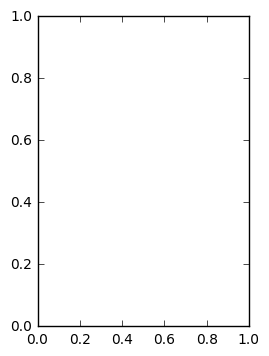

In [4]:
# replay record
with torch.no_grad():
    for i in range(1000):
        timestep = dataset_train[i]
        obs = timestep["s0"][0, ...]
        obs = timestep["s0"]
        
        clear_output(True)
        plt.subplot(121)
        plt.imshow(obs.permute([2,1,0]))
    #     obs = resize(obs, (64, 64))
        plt.subplot(122)
#         obs = model(timestep["s0"].unsqueeze(0).cuda())[0].squeeze(0).cpu()
        plt.imshow(obs.permute([2,1,0]))

    #     plt.imshow(timestep["s0"])
#         print("reward", timestep['r1'])
#         print("action", timestep['a0'])
        plt.pause(0.1)

In [ ]:
timestep

In [ ]:
obs.size()

In [5]:
pred = AE_Predictor()

In [6]:
pred.generate_predictions(timestep["s0"].unsqueeze(0), timestep["a0"].unsqueeze(0), None)

torch.Size([1, 1, 256])


ZeroDivisionError: float division by zero

In [ ]:
batch_size = 4
series_len = 15
h, w, c = 64, 64, 3

image = torch.rand(batch_size, series_len, c, h, w)
print(image.size())

In [ ]:
a = pred(image)

In [ ]:
a.size()

In [ ]:
from pred_learn.models.ae import ActionEncoder

In [ ]:
net = ActionEncoder(3)

In [ ]:
import numpy as np

In [ ]:
actions = torch.LongTensor(np.random.randint(0, 3, 100))
actions

In [ ]:
net(actions).size()